In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from collections import Counter

from kneebow.rotor import Rotor

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

### DBSCAN Applied only to DB5 Observations

In [3]:
R = pd.read_csv("../data/R.csv") #reintroduce dataset | log data
subset_ids = pd.read_csv("../data/R_ids_alpha_0.9153.csv")

data = R[R.id.isin(subset_ids.id.values)]

In [4]:
# 'MAST', 'NSTX': are spherical tokamaks
data.TOK.unique()

array(['AUG', 'AUGW', 'D3D', 'JET', 'JETILW', 'JT60U', 'MAST', 'NSTX'],
      dtype=object)

In [5]:
# Scaled data

X = StandardScaler().fit_transform(data[coeffs])
pd.DataFrame(X, columns=coeffs)

,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF
0,-0.331526,0.838919,1.287848,-1.486056,-0.673402,0.519328,-0.639600,0.009252
1,-0.331526,0.838919,1.378730,-1.501955,-0.676666,0.410631,-0.616332,0.009252
2,-0.329639,0.836696,0.989826,-1.716891,-0.678299,0.519328,-0.632700,0.009252
3,-1.249247,-0.370778,1.050781,-0.933778,-0.702919,0.268309,-0.470774,0.009252
4,-1.252649,-0.369496,1.065977,-0.903222,-0.709522,0.102640,-0.419011,0.009252
...,...,...,...,...,...,...,...,...
1246,-0.765730,-3.369614,0.043594,-1.253172,-2.465181,3.879360,3.736411,0.009252
1247,-0.764129,-3.370114,0.291230,-0.860210,-2.399232,3.178814,3.718674,0.009252
1248,-1.006378,-3.369113,-0.174843,-0.906633,-2.483505,3.003939,3.960551,0.009252
1249,-1.266881,-3.369614,-0.289471,-2.133162,-2.486677,2.216867,3.717324,0.009252


## The choosing of the parameters for DBSCAN

* It is recommended that $minPts = 2\cdot d$; where $d$ is the dimension of the data (Sander et al., 1998).
* Now one can use this to determine $\epsilon$.
    1. Calculate the average distance between each point and its k-nearest neighbor: with $k = minPts$. 
    2. Plot the average distance in ascending order, on a k-distance graph. 
    3. Optimal value of $\epsilon$ is the point of maximum curvature.
        - This point represents the optimization point where diminishing results are no longer worth the additional cost. This reasoning is valid since the increasment of the number of clusters will lead to a tendency of overfitting.  

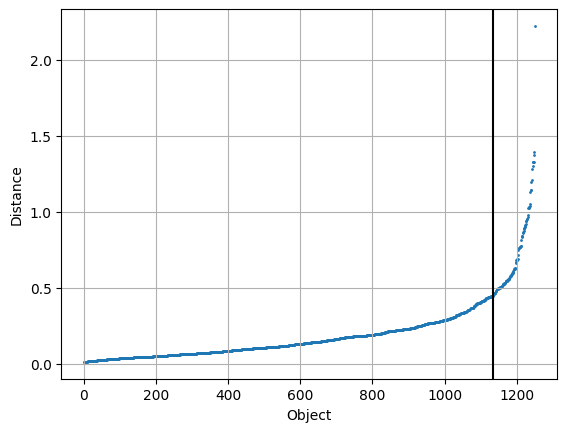

In [33]:
### Computing the optimal epsilon

#%matplotlib notebook

NNeighbours = 2*X.shape[-1]

# getting the average distance
neighbors = NearestNeighbors(n_neighbors = NNeighbours)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

x = list(range(len(distances)))

plt.scatter(x, distances, s=1)

data_elbow = (pd.DataFrame([x, distances]).T).values.tolist()
rotor = Rotor()
rotor.fit_rotate( data_elbow )
elbow_index = rotor.get_elbow_index()
plt.axvline(elbow_index, c="k")
#plt.axvline(1204, c="r")

#plt.axis([900, max(x), min(distances), max(distances)])

plt.ylabel("Distance")
plt.xlabel("Object")
plt.grid();

In [7]:
distances[elbow_index]

0.4473339590905177

In [8]:
# Label -1 means noise
DB = DBSCAN(eps = distances[elbow_index], min_samples=NNeighbours ).fit(X)
labels = DB.labels_
data.insert(loc=0, column="labels", value=labels)
Counter(labels)

Counter({-1: 570,
         4: 22,
         0: 71,
         1: 148,
         2: 22,
         3: 16,
         5: 66,
         6: 198,
         7: 117,
         8: 21})

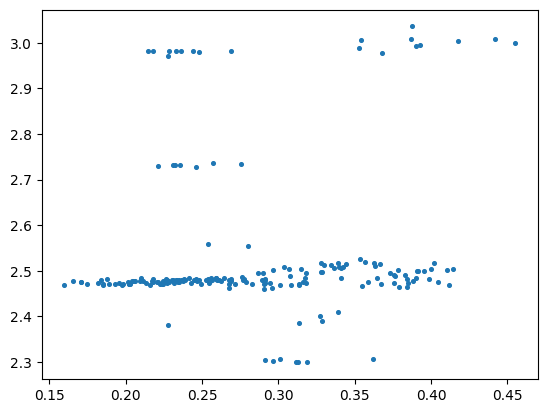

In [31]:
data_cl = data[~data.labels.isin([-1])]
data_cl_max = data_cl[data_cl.labels.isin([6])]

plt.scatter(data_cl_max["TAUTH"].apply(np.exp), data_cl_max["IP"].apply(np.exp), s=7);

### Possible numbers of clusters in dataset

In [15]:
np.sqrt(len(data)/2)

25.0099980007996

In [24]:
data_cl_max.columns

Index(['labels', 'ind', 'id', 'PHASE', 'TOK', 'IP', 'BT', 'NEL', 'PLTH',
       'RGEO', 'KAREA', 'EPS', 'MEFF', 'TAUTH', 'DATE', 'SHOT', 'TIME', 'Q95',
       'ZEFF', 'AMIN', 'VOL', 'POHM', 'PNBI', 'DWDIA', 'DWMHD', 'PICRH',
       'PECRH', 'PL', 'PFLOSS', 'TAV', 'LCOULOMB', 'QCYL5', 'TAUBOHM',
       'RHOSTAR', 'BETASTAR', 'NUSTAR', 'OMEGACYCL'],
      dtype='object')